# Signal Modulation classification 4
Experiment with architecture and data

## Imports

In [1]:
# imports
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from pathlib import Path
import glob
import time
from scipy import io
from typing import Tuple
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("..") # not good
from tools.data import load_data_simc_v1, load_data_radioml_v1

2023-04-30 18:15:31.420037: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-30 18:15:31.447718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 18:15:31.937958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-04-30 18:15:33.114724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-30 18:15:33.118793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-30 18:15:33.118909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading for model training/evaluation/training

Please refer to ../generate_data.py to generate data

All confiuguration should be in the cell below

In [4]:
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

N_CLASSES = len(modulations)
MODEL_DATA_TYPE = np.float32
N_SAMPLES = 1024


SEED = 123456
set_seed(SEED)

# Training
train_model = True
N_EPOCHS = 12
BATCH_SIZE = 128
# TRAIN_DATA_DIR = "/development/data/RML2016.10a/RML2016.10a_dict.pkl" # radioml dataset
TRAIN_DATA_DIR = "/development/data/train_data_SIMC1_SNR_mixed_0-30_30k"

# Deployment
# model_name = "simc_2_mixed_0-30_data"
model_name = "simc_4_radioml_22"
# model_name = "simc_4_radioml_cnn"
# MODELS_DIR = f'models_{model_name}_MIXED_0-30_DATA/'
MODELS_DIR = f'models_{model_name}/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'
snrs = [0, 5, 10, 15, 20, 25, 30]

Explore dataset used in Convolutional Radio Modulation Recognition Networks

In [5]:
reload_module("tools.data")
from tools.data import load_data_simc_v1, load_data_radioml_v1
labels, data, modulations = load_data_radioml_v1(TRAIN_DATA_DIR, to_1024=False)

In [6]:
print(modulations)
print(labels.shape)
print(data.shape)

['CPFSK', '8PSK', 'QAM64', 'QAM16', 'WBFM', 'PAM4', 'QPSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'GFSK']
(220000,)
(220000, 1, 128, 2)


### Data preprocessing

In [7]:
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)
n_validation = int(0.1 * DS_SIZE)
n_test = DS_SIZE - n_train - n_validation

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)


In [8]:
train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [9]:
# Should save some memory
del data
del labels

## Model creation


In [10]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

In [11]:
from numpy import random
 
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process
 
queries = random.random((batch_size, input_seq_length, d_k))
keys = random.random((batch_size, input_seq_length, d_k))
values = random.random((batch_size, input_seq_length, d_v))
 
multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
# print(multihead_attention(queries, keys, values))
multihead_attention(queries, keys, values)
print()

2023-04-30 18:15:35.412312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-30 18:15:35.412513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-30 18:15:35.412587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-04-30 18:15:36.269110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P


    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [13]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)
print(vectorized_phrases.shape)
print(vectorized_phrases)

# random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
#                                                         total_vocabulary,
#                                                         final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
# random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)
print(fixed_embedding.shape)
# print(fixed_embedding)

(2, 20)
tf.Tensor(
[[ 3  2 20 22 35  8 17  3  2 32 11 33 27  4  7 28 25  4  7 18]
 [14 26 13  6  5 21 15  6  5 30  9 24 12 10 31 23 19  0  0  0]], shape=(2, 20), dtype=int64)
(2, 20, 50)


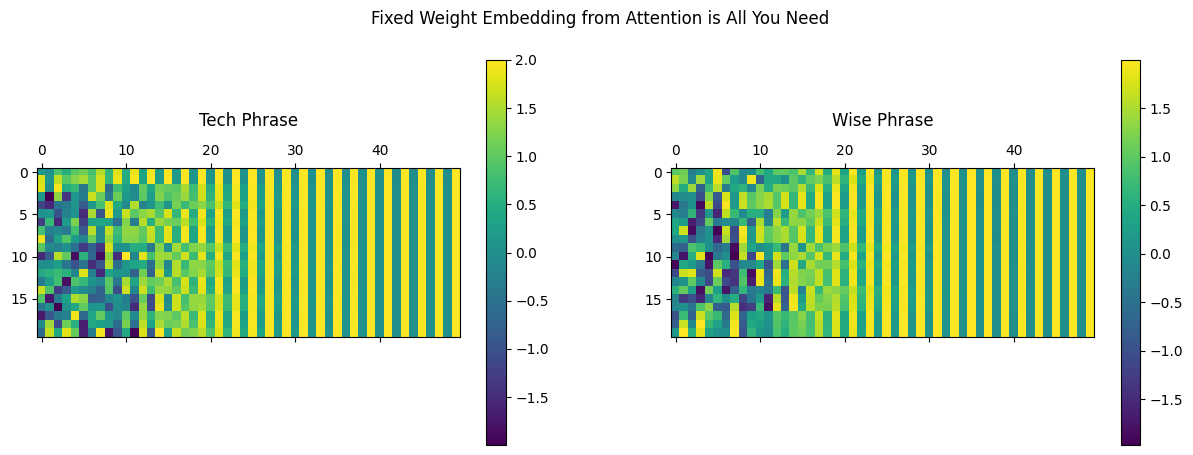

In [14]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()

In [15]:
from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout
# from multihead_attention import MultiHeadAttention
# from positional_encoding import PositionEmbeddingFixedWeights

# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = LayerNormalization()  # Layer normalization layer

    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x

        # Apply layer normalization to the sum
        return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer

    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)

        return self.fully_connected2(self.activation(x_fc1))

# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)

        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)

# Implementing the Encoder
class Encoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, input_sentence, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)

        return x

In [16]:
from numpy import random

enc_vocab_size = 20 # Vocabulary size for the encoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack

batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

input_seq = random.random((batch_size, input_seq_length))

encoder = Encoder(enc_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
encoder(input_seq, None, True)
print()

2023-04-30 18:15:37.073486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


In [17]:
# Implementing the Encoder
class SIMC_Encoder(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(SIMC_Encoder, self).__init__(**kwargs)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, inp, padding_mask, training):
        # Add in a dropout layer
        x = self.dropout(inp, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)

        return x

In [18]:
h = 4  # Number of self-attention heads
d_k = 16  # Dimensionality of the linearly projected queries and keys
d_v = 16  # Dimensionality of the linearly projected values
d_ff = 128  # Dimensionality of the inner fully connected layer
d_model = 128  # Dimensionality of the model sub-layers' outputs
n = 4  # Number of layers in the encoder stack
n_c = 32

batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

input_seq = random.random((batch_size, n_c, d_model))

encoder = SIMC_Encoder(h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(encoder(input_seq, None, True).shape)
print()
print(encoder.count_params())

(64, 32, 128)

167616


In [19]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )
# [1 ]
def create_model_simc_3_stable():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(32, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(48, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(64, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(96, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(128, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

def create_model_simc_3_inp_128(k=8):
    InputLayer = keras.Input(shape=(1, 128, 2))
    CNN1 = layers.Conv2D(32, (1, k), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    # MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    # CNN2 = layers.Conv2D(48, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    CNN2 = layers.Conv2D(48, (1, k), padding="same", name="CNN2_")(ReLU1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(64, (1, k), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    # MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    # CNN4 = layers.Conv2D(96, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    CNN4 = layers.Conv2D(96, (1, k), padding="same", name="CNN4_")(ReLU3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(128, (1, k), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    # MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    # CNN6 = layers.Conv2D(192, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    CNN6 = layers.Conv2D(192, (1, k), padding="same", name="CNN6_")(ReLU5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_transformer_10(k=65, n_c=32, h=4, d_k=64, d_v=64, dff=512, N=4):
    InputLayer = keras.Input(shape=(128, 2))
    # (b, 128, 2)
    CNN1 = layers.Conv1D(n_c, k, padding="same", name="CNN1_")(InputLayer)
    RELU1 = layers.ReLU(name="RELU1_")(CNN1)

    # (b, 128, 32)
    PM1 = layers.Permute((2, 1), name="PM1_")(RELU1)

    # (b, 32, 128)
    ENC1 = SIMC_Encoder(h, d_k=16, d_v=16, d_model=128, d_ff=128, n=N, rate=0.1, name="ENC1_")(PM1, None, True)
    # ENC1 = SIMC_Encoder(h, d_k=d_k, d_v=d_v, d_model=128, d_ff=dff, n=N, rate=0.1, name="ENC1_")(PM1, None, True)

    # (b, 32, 128)
    # AVG1 = layers.MaxPool1D(8, padding="same", name="AVG1_")(ENC1)
    AVG1 = layers.AveragePooling1D(32, padding="same", name="AVG1_")(ENC1)
    # AVG1 = layers.AveragePooling1D(32, padding="same", name="AVG1_")(PM1)

    # (b, 1, 128)
    FLT1 = layers.Flatten(name="FLT1_")(AVG1)

    # (b, 128)
    FC1 = layers.Dense(128, name="FC1_")(FLT1)
    RELU2 = layers.ReLU(name="RELU2_")(FC1)

    # (b, 128)
    FC2 = layers.Dense(len(modulations), name="FC2_")(RELU2)

    # (b, 11)
    Output = layers.Softmax()(FC2)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

def create_model_transformer_20(k=65, n_c=32, h=4, d_k=64, d_v=64, dff=512, N=4):
    InputLayer = keras.Input(shape=(128, 2))
    # (b, 128, 2)
    CNN1 = layers.Conv1D(n_c, k, padding="same", name="CNN1_")(InputLayer)
    RELU1 = layers.ReLU(name="RELU1_")(CNN1)

    # (b, 128, 32)
    ENC1 = SIMC_Encoder(h, d_k=32, d_v=32, d_model=32, d_ff=128, n=N, rate=0.1, name="ENC1_")(RELU1, None, True)
    # ENC1 = SIMC_Encoder(h, d_k=d_k, d_v=d_v, d_model=128, d_ff=dff, n=N, rate=0.1, name="ENC1_")(PM1, None, True)

    # (b, 128, 32)
    # AVG1 = layers.MaxPool1D(8, padding="same", name="AVG1_")(ENC1)
    AVG1 = layers.AveragePooling1D(32, padding="same", name="AVG1_")(ENC1)
    # AVG1 = layers.AveragePooling1D(32, padding="same", name="AVG1_")(PM1)

    # (b, 4, 32)
    FLT1 = layers.Flatten(name="FLT1_")(AVG1)

    # (b, 128)
    FC1 = layers.Dense(128, name="FC1_")(FLT1)
    RELU2 = layers.ReLU(name="RELU2_")(FC1)

    # (b, 128)
    FC2 = layers.Dense(len(modulations), name="FC2_")(RELU2)

    # (b, 11)
    Output = layers.Softmax()(FC2)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_transformer_21(k=65, n_c=32, h=4, d_k=64, d_v=64, dff=512, N=4):
    InputLayer = keras.Input(shape=(128, 2))
    # (b, 128, 2)
    CNN1 = layers.Conv1D(32, k, padding="same", name="CNN1_")(InputLayer)
    RELU1 = layers.ReLU(name="RELU1_")(CNN1)

    CNN2 = layers.Conv1D(64, k, padding="same", name="CNN2_")(RELU1)
    RELU2 = layers.ReLU(name="RELU2_")(CNN2)

    # (b, 128, 64)
    ENC1 = SIMC_Encoder(h, d_k=32, d_v=32, d_model=64, d_ff=256, n=N, rate=0.1, name="ENC1_")(RELU2, None, True)
    # ENC1 = SIMC_Encoder(h, d_k=d_k, d_v=d_v, d_model=128, d_ff=dff, n=N, rate=0.1, name="ENC1_")(PM1, None, True)

    # (b, 128, 64)
    # AVG1 = layers.MaxPool1D(8, padding="same", name="AVG1_")(ENC1)
    AVG1 = layers.AveragePooling1D(32, padding="same", name="AVG1_")(ENC1)
    # AVG1 = layers.AveragePooling1D(32, padding="same", name="AVG1_")(PM1)

    # (b, 4, 64)
    FLT1 = layers.Flatten(name="FLT1_")(AVG1)

    # (b, 256)
    FC1 = layers.Dense(128, name="FC1_")(FLT1)
    RELU3 = layers.ReLU(name="RELU3_")(FC1)

    # (b, 128)
    FC2 = layers.Dense(len(modulations), name="FC2_")(RELU3)

    # (b, 11)
    Output = layers.Softmax()(FC2)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model



In [29]:
# model = create_model_transformer_20(N=4)
model = create_model_transformer_21()
# model = create_model_simc_3_stable()
# model = create_model_simc_3_inp_128(k=8)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN1_ (Conv1D)              (None, 128, 32)           4192      
                                                                 
 RELU1_ (ReLU)               (None, 128, 32)           0         
                                                                 
 CNN2_ (Conv1D)              (None, 128, 64)           133184    
                                                                 
 RELU2_ (ReLU)               (None, 128, 64)           0         
                                                                 
 ENC1_ (SIMC_Encoder)        (None, 128, 64)           166784    
                                                                 
 AVG1_ (AveragePooling1D)    (None, 4, 64)             0   

In [30]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [31]:
train_data = train_data.squeeze()
validation_data = validation_data.squeeze()
test_data = test_data.squeeze()

# train_data = np.expand_dims(train_data, 1)
# validation_data = np.expand_dims(validation_data, 1)
# test_data = np.expand_dims(test_data, 1)

In [32]:
def step_decay(epoch):
    # lrate=0.001
    lrate = 0.001
    factor = epoch // 6
    lrate /= (10**factor)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)


N_EPOCHS = 24
BATCH_SIZE = 128
if train_model:
    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels), 
        callbacks=[lrate]
    )
else:
    model = tf.keras.models.load_model(MODEL_TF)


Epoch 1/24
1375/1375 [==============================] - 55s 35ms/step - loss: 1.7349 - accuracy: 0.3304 - val_loss: 1.4275 - val_accuracy: 0.4329 - lr: 0.0010
Epoch 2/24
1375/1375 [==============================] - 48s 35ms/step - loss: 1.4038 - accuracy: 0.4430 - val_loss: 1.3120 - val_accuracy: 0.4877 - lr: 0.0010
Epoch 3/24
1375/1375 [==============================] - 48s 35ms/step - loss: 1.2816 - accuracy: 0.4948 - val_loss: 1.2450 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 4/24
1375/1375 [==============================] - 48s 35ms/step - loss: 1.2370 - accuracy: 0.5078 - val_loss: 1.2289 - val_accuracy: 0.5120 - lr: 0.0010
Epoch 5/24
1375/1375 [==============================] - 48s 35ms/step - loss: 1.2164 - accuracy: 0.5159 - val_loss: 1.2090 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 6/24
1375/1375 [==============================] - ETA: 0s - loss: 1.1985 - accuracy: 0.5291

In [196]:
# for var in model.weights:
#     print(var.name)
#     print(f"Less than 1e-10 : {np.sum(var.numpy() < 1e-10)} / {var.numpy().size}")
#     print(f"Nans : {np.sum(np.isnan(var.numpy()))} / {var.numpy().size}")

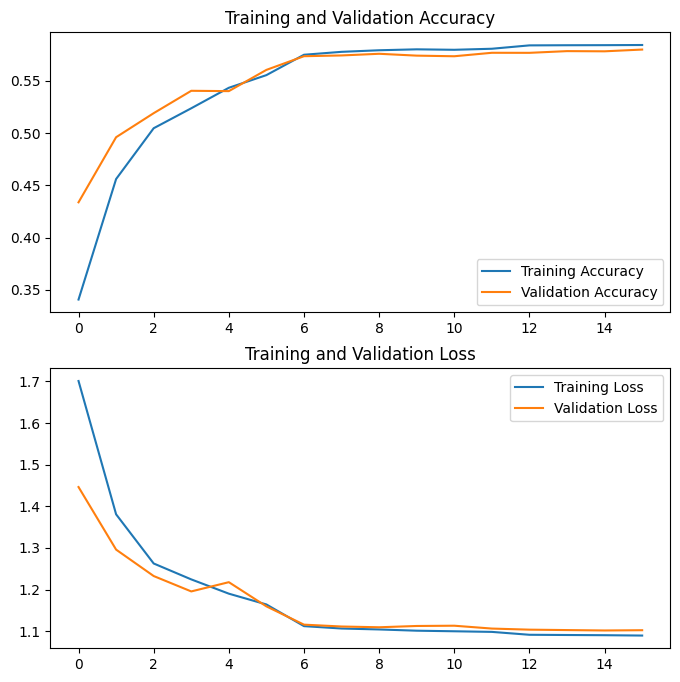

In [214]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [215]:
def evaluate_model(model, data, labels):
    preds = model.predict(data)
    pred_labels = np.argmax(preds, axis=1)

    print(f"Overall test accuracy: {accuracy_score(labels, pred_labels)}")
    for ci, cl in enumerate(modulations):
        class_indecies = np.where(labels == ci)[0]
        cur_true_labels = labels[class_indecies]
        cur_pred_labels = pred_labels[class_indecies]
        print(f"{cl} test accuracy: {accuracy_score(cur_true_labels, cur_pred_labels)}")
    cm = confusion_matrix(y_true=labels, y_pred=pred_labels)
    df_cm = pd.DataFrame(cm, index = modulations,
                    columns = modulations)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)


688/688 [==============================] - 8s 11ms/step
Overall test accuracy: 0.5787727272727273
BPSK test accuracy: 0.6081218274111675
GFSK test accuracy: 0.6547263681592039
CPFSK test accuracy: 0.6230498238550579
QAM64 test accuracy: 0.5487382483918852
AM-DSB test accuracy: 0.7124505928853755
QAM16 test accuracy: 0.2413793103448276
PAM4 test accuracy: 0.7006595636732623
8PSK test accuracy: 0.5262376237623763
WBFM test accuracy: 0.2681592039800995
AM-SSB test accuracy: 0.9355163727959698
QPSK test accuracy: 0.5625321667524447


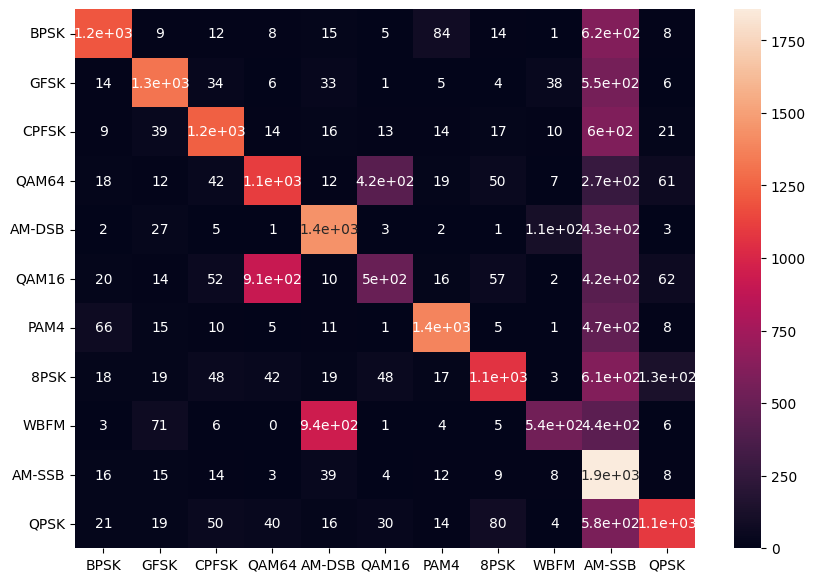

In [216]:
evaluate_model(model, validation_data, validation_labels)

In [217]:
import pickle
# evaluate by snr radioml
def get_snrs(indecies, to_1024=False, minimum_snr=-100):
    with open(TRAIN_DATA_DIR, 'rb') as crmrn_file:
        raw_ds = pickle.load(crmrn_file, encoding="bytes")
    decoded_raw_ds = {}
    for (class_name_bytes, snr), raw_data in raw_ds.items():
        if snr < minimum_snr:
            continue
        decoded_raw_ds[(class_name_bytes.decode("utf-8"), snr)] = raw_data
    raw_ds = decoded_raw_ds

    samples_per_snr_per_modulation = raw_ds[list(raw_ds.keys())[0]].shape[0] # 1000
    snrs_sequence = [k[1] for k in raw_ds.keys()]
    result = []
    snrs = [snrs_sequence[idx // samples_per_snr_per_modulation] for idx in indecies]
    return np.array(snrs)



snrs = get_snrs(validation_indecies, False)

In [218]:
print(min(snrs), max(snrs))
print(type(snrs))

-20 18
<class 'numpy.ndarray'>


In [219]:
def get_snr_to_acc(model, data, labels, snrs):
    snr_to_acc = {}
    for snr in range(min(snrs), max(snrs)+2, 2):
        cur_indecies = np.where(snrs == snr)[0]
        cur_data = data[cur_indecies]
        cur_labels = labels[cur_indecies]
        # print(snr)
        # print(cur_indecies)
        # print(cur_data)
        cur_pred = model.predict(cur_data, verbose=0)

        cur_pred_labels = np.argmax(cur_pred, axis=1)
        print(f"snr={snr}")
        acc = accuracy_score(cur_labels, cur_pred_labels)
        print(f"Overall test accuracy: {acc}")
        snr_to_acc[snr] = acc
    return snr_to_acc

snr_to_acc = get_snr_to_acc(model, validation_data, validation_labels, snrs)


snr=-20
Overall test accuracy: 0.09317343173431734
snr=-18
Overall test accuracy: 0.09304511278195489
snr=-16
Overall test accuracy: 0.0890652557319224
snr=-14
Overall test accuracy: 0.15145985401459855
snr=-12
Overall test accuracy: 0.14740673339399454
snr=-10
Overall test accuracy: 0.24319419237749546
snr=-8
Overall test accuracy: 0.40949820788530467
snr=-6
Overall test accuracy: 0.5658263305322129
snr=-4
Overall test accuracy: 0.6861652739090065
snr=-2
Overall test accuracy: 0.7225636523266022
snr=0
Overall test accuracy: 0.8097876269621422
snr=2
Overall test accuracy: 0.8365472910927456
snr=4
Overall test accuracy: 0.8494809688581315
snr=6
Overall test accuracy: 0.845662100456621
snr=8
Overall test accuracy: 0.8471337579617835
snr=10
Overall test accuracy: 0.8389904264577894
snr=12
Overall test accuracy: 0.8462946020128088
snr=14
Overall test accuracy: 0.827683615819209
snr=16
Overall test accuracy: 0.8402255639097744
snr=18
Overall test accuracy: 0.8342198581560284


In [220]:
import time
from tqdm import trange
start_time=time.time()
model.predict(validation_data)
end_time=time.time()
duration= (end_time-start_time) / (validation_data.shape[0])
print(f"Inference time: {duration * 1000}ms")

688/688 [==============================] - 8s 12ms/step
Inference time: 0.37542426586151123ms


In [148]:
# evaluate by snr mixed
# snrs = list(range(0, 30))
# def snr_by_idx(idx):
#     snr_idx = (idx % 30000) // 1000
#     return snrs[snr_idx]


In [149]:
# print(test_indecies[:40])
# test_snrs = np.array([snr_by_idx(idx) for idx in test_indecies])
# print(test_snrs[:40])
# print(test_indecies.shape)

In [150]:
# snr_to_acc = {}
# for snr in range(0, 30):
#     cur_test_indecies = np.where(test_snrs == snr)[0]
#     cur_test_data = test_data[cur_test_indecies]
#     cur_test_labels = test_labels[cur_test_indecies]
#     cur_pred = model.predict(cur_test_data, verbose=0)

#     cur_pred_labels = np.argmax(cur_pred, axis=1)
#     print(f"snr={snr}")
#     acc = accuracy_score(cur_test_labels, cur_pred_labels)
#     print(f"Overall test accuracy: {acc}")
#     snr_to_acc[snr] = acc


(0.0, 1.0)

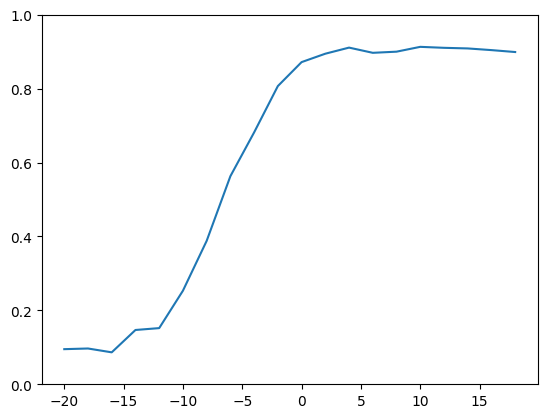

In [173]:
plt.plot(list(snr_to_acc.keys()), list(snr_to_acc.values()))
plt.ylim([0, 1])

In [33]:
# plt.plot([0, 5, 10, 15, 20, 25, 30], [0.49772727272727274 ,0.6522727272727272, 0.7654545454545455, 0.8245454545454546, 0.8581818181818182, 0.86, 0.8686363636363637])
# plt.ylim([0, 1])

### Mode deployment

In [28]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models_simc_4_radioml_cnn/model/assets


INFO:tensorflow:Assets written to: models_simc_4_radioml_cnn/model/assets


In [222]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite
model_no_quant_tflite = to_tf_lite(MODEL_TF)
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

2023-04-30 17:40:12.569214: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-04-30 17:40:12.569244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-04-30 17:40:12.569800: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models_simc_4_radioml/model
2023-04-30 17:40:12.578442: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-30 17:40:12.578461: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models_simc_4_radioml/model
2023-04-30 17:40:12.609636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-04-30 17:40:12.617302: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-04-30 17:40:12.832090: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: mo

417112

In [223]:
# reload_module("tools.deployment_tools")
# from tools.deployment_tools import deploy_model_tflite

# deploy_model_tflite(
#     model_no_quant_tflite,
#     # test_data.reshape((-1, 1, 1, 1024, 2)),
#     test_data,
#     test_labels, 
#     model_name=model_name,
#     classes=modulations,
#     create_cfu_playground_proj=True,
# )

## Quantization
Let's quantize model, and check accuracy

In [225]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite

representative_ds = train_data[:2000].astype(np.float32)
print(representative_ds.dtype)
print(representative_ds.shape)
model_tflite = to_tf_lite(MODEL_TF, representative_ds=representative_ds, apply_quantization=True)
open(MODEL_TFLITE, "wb").write(model_tflite)

float32
(2000, 128, 2)


2023-04-30 17:41:01.392735: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-04-30 17:41:01.392761: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-04-30 17:41:01.392928: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models_simc_4_radioml/model
2023-04-30 17:41:01.402209: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-30 17:41:01.402234: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models_simc_4_radioml/model
2023-04-30 17:41:01.437791: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-04-30 17:41:01.640757: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: models_simc_4_radioml/model
2023-04-30 17:41:01.710369: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; 

217672

In [226]:
from tools.deployment_tools import predict_tflite

test_preds_quant = np.squeeze(predict_tflite(model_tflite, test_data))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [227]:
pred_labels_quant = np.argmax(test_preds_quant, axis=1)
print(pred_labels_quant[:10])
print(test_labels[:10])

[ 3  9  4  9  9 10 10  9  1  3]
[ 5  9  4  3 10  5 10  9  8  5]


Overall test accuracy: 0.5743181818181818
BPSK test accuracy: 0.6071956628881222
GFSK test accuracy: 0.6669898206495395
CPFSK test accuracy: 0.6033057851239669
QAM64 test accuracy: 0.6403336604514229
AM-DSB test accuracy: 0.6809933142311366
QAM16 test accuracy: 0.19583333333333333
PAM4 test accuracy: 0.6983723296032553
8PSK test accuracy: 0.5196770938446014
WBFM test accuracy: 0.269482151835093
AM-SSB test accuracy: 0.8941772151898734
QPSK test accuracy: 0.521414342629482


<Axes: >

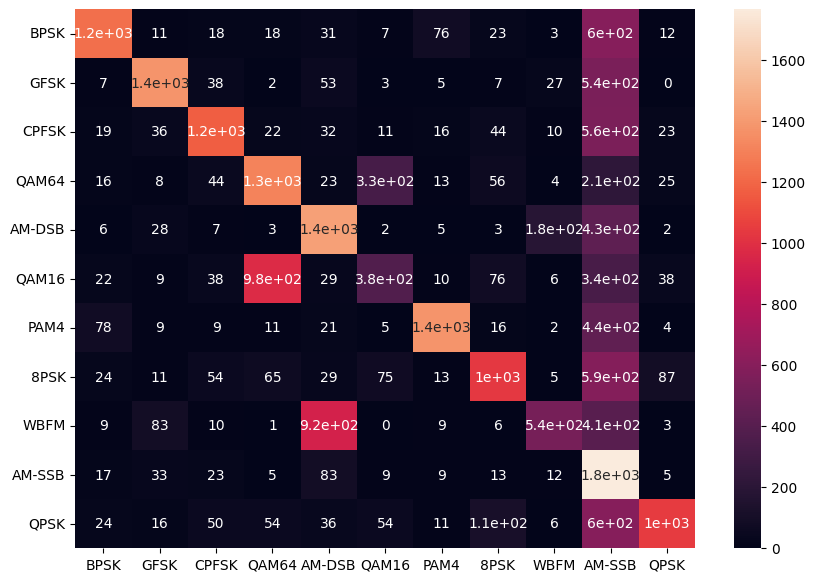

In [228]:
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels_quant)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels_quant[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")

cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels_quant)
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [229]:
print(test_preds_quant.dtype)
print(test_preds_quant[0])

float32
[0.015625   0.03125    0.1484375  0.24609375 0.00390625 0.20703125
 0.015625   0.17578125 0.0234375  0.00390625 0.125     ]


In [230]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import deploy_model_tflite

deploy_model_tflite(
    # model_no_quant_tflite,
    model_tflite,
    test_data,
    test_labels, 
    model_name=model_name,
    classes=modulations,
    create_cfu_playground_proj=False,
    epsilon=20,
    apply_quantization=True,
)

[debug] Export test data


11it [00:00, 231.72it/s]
